In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

qml.QubitStateVector = qml.StatePrep
from non_dynamical_ansatz import fixed_layered_ansatz
from variational_lse_solver import VarLSESolver


"""
To run this script you need the following packages:
- PennyLane (but the latest version does not have the QubitStateVector class (which is needed), so we redefine it above)
- Numpy < 2: need to install something like numpy 1.26.4
- Python 3.12
- torch 2.2.2
"""


'\nTo run this script you need the following packages:\n- PennyLane (but the latest version does not have the QubitStateVector class (which is needed), so we redefine it above)\n- Numpy < 2: need to install something like numpy 1.26.4\n- Python 3.12\n- torch 2.2.2\n'

In [2]:
# unitary representation of Paulis
I_ = np.array([[1.0, 0.0], [0.0, 1.0]])
X_ = np.array([[0.0, 1.0], [1.0, 0.0]])
Y_ = np.array([[0.0, -1.j], [1.j, 0.0]])
Z_ = np.array([[1.0, 0.0], [0.0, -1.0]])

a = ["III", "XZI", "XII"]
b = np.ones(8)/np.sqrt(8)

In [ ]:
n_qubits = 3
depth = 4
param_shape = (n_qubits + depth*(n_qubits+n_qubits-2),)


N_runs = 2
local_static_results = np.zeros([N_runs, len(b)])
local_dynamic_results = np.zeros([N_runs, len(b)])

for i in range(N_runs):
    lse_static_local = VarLSESolver(a, 
                b, 
                coeffs=[1.0, 0.2, 0.2], 
                method="hadamard", 
                local=True, 
                ansatz=fixed_layered_ansatz,
                weights=param_shape,
                lr=0.1, 
                steps=50,
                epochs=10) #Epochs: max circuit depth for dynamic circuit


    lse_dynammic_local = VarLSESolver(a, 
                b, 
                coeffs=[1.0, 0.2, 0.2], 
                method="hadamard", 
                local=True, 
                lr=0.1, 
                steps=50,
                epochs=10) #Epochs: max circuit depth for dynamic circuit
    
    solution_static_local, _ = lse_static_local.solve()
    solution_dynamic_local, _ = lse_dynammic_local.solve()

    local_static_results[i,:] = solution_static_local
    local_dynamic_results[i,:] = solution_dynamic_local




/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/10: 100%|██████████| 50/50 [00:03<00:00, 15.45it/s, best loss=0.00158, last improvement in step=27, loss=0.00223]
Increasing circuit depth.
Epoch 2/10:  58%|█████▊    | 29/50 [00:01<00:01, 14.57it/s, best loss=0.0149, last improvement in step=29, loss=0.0149]


KeyboardInterrupt: 

In [66]:
# compute normalized classical solution for comparison, therefore first re-compose system matrix A
A = 1.0 * np.kron(I_, np.kron(I_, I_)) + 0.2 * np.kron(X_, np.kron(Z_, I_)) + 0.2 * np.kron(X_, np.kron(I_, I_))
classical_solution = np.linalg.solve(A, b)
normalized_classical_solution = np.square(classical_solution / np.linalg.norm(classical_solution))

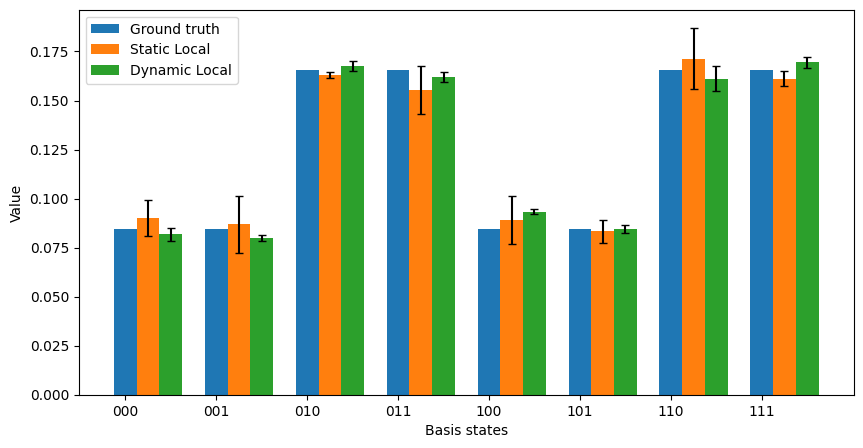

In [67]:
plt.figure(figsize=(10, 5))

x = np.arange(len(normalized_classical_solution)) 
width = 0.25 
multiplier = 0

plt.bar(x, normalized_classical_solution, width = width, label='Ground truth')
plt.bar(x + width, np.mean(local_static_results, axis=0), yerr=np.std(local_static_results,axis=0)/np.sqrt(len(local_static_results)), width=width, capsize=3, label='Static Local')
plt.bar(x + 2*width, np.mean(local_dynamic_results, axis=0), yerr=np.std(local_dynamic_results, axis=0)/np.sqrt(len(local_dynamic_results)), width=width, capsize=3, label='Dynamic Local')

plt.legend()
plt.xticks(x, ['000', '001', '010', '011', '100', '101', '110', '111'])
plt.xlabel('Basis states')
plt.ylabel('Value')
plt.show()